In [1]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

In [5]:
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

In [3]:
query = """
    SELECT longitude, latitude
    FROM `tidal-digit-291220.safegraph.places`
    WHERE city = 'New York' AND region = 'NY'
        """

In [4]:
df = bqclient.query(query).result().to_dataframe()

In [5]:
X, Y = lnglat_to_meters(df['longitude'], df['latitude'])

df['X'] = X
df['Y'] = Y

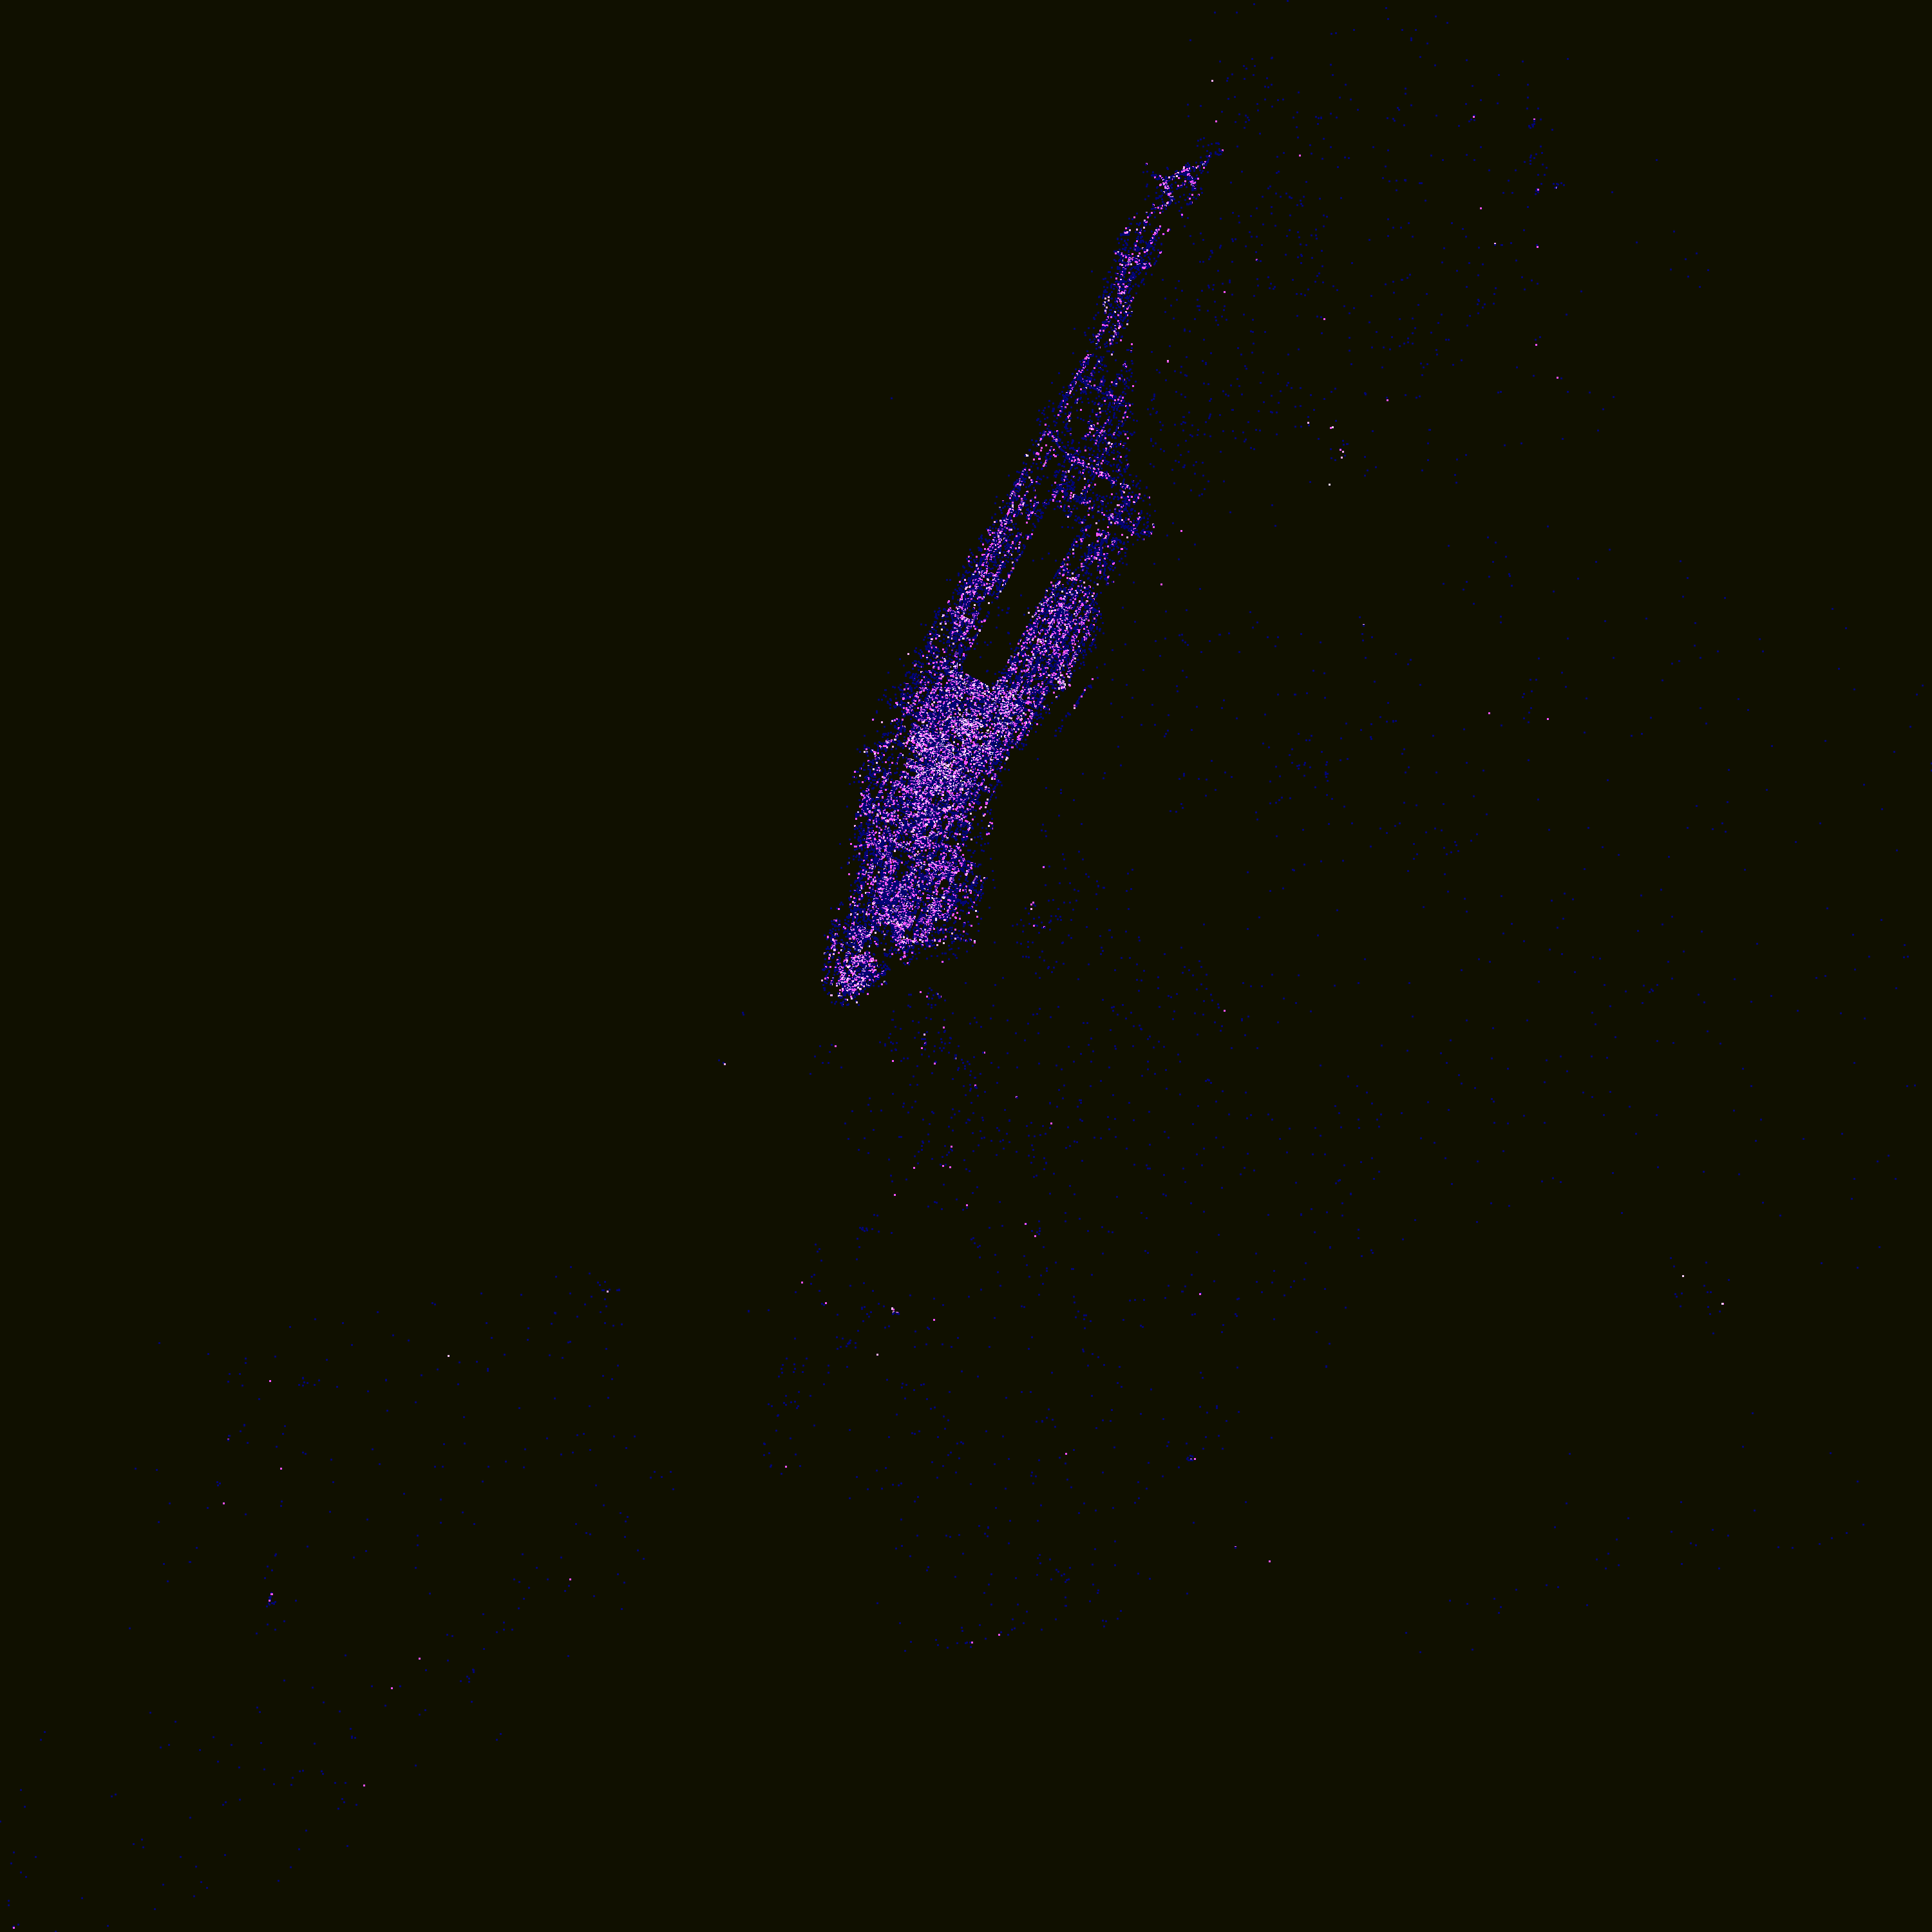

In [6]:
df['outlier_x'] = pd.qcut(df.X, 100, labels=False)
df['outlier_y'] = pd.qcut(df.Y, 100, labels=False)

for i in np.arange(1, 10):
    df = df[(df['X']!=df['X'].min()) & (df['Y']!=df['Y'].min())]
    df = df[(df['X']!=df['X'].max()) & (df['Y']!=df['Y'].max())]

range_x = (df['X'].min(), df['X'].max())
range_y = (df['Y'].min(), df['Y'].max())

wi = int(3000)
hi = int(3000)

cvs = ds.Canvas(plot_width=wi, plot_height=hi, x_range=range_x, y_range=range_y)
agg = cvs.points(df, "X", "Y", agg=ds.count())
img = tf.shade(agg, cmap=palette['CET_L7'][20:], how="eq_hist")
img = tf.spread(img, px=1, how='saturate')
img = tf.set_background(img, "#101000")

img

In [7]:
query = """
    SELECT longitude, latitude
    FROM `tidal-digit-291220.safegraph.places`
    WHERE city = 'Los Angeles' AND region = 'CA'
        """

In [8]:
df = bqclient.query(query).result().to_dataframe()

In [9]:
X, Y = lnglat_to_meters(df['longitude'], df['latitude'])

df['X'] = X
df['Y'] = Y

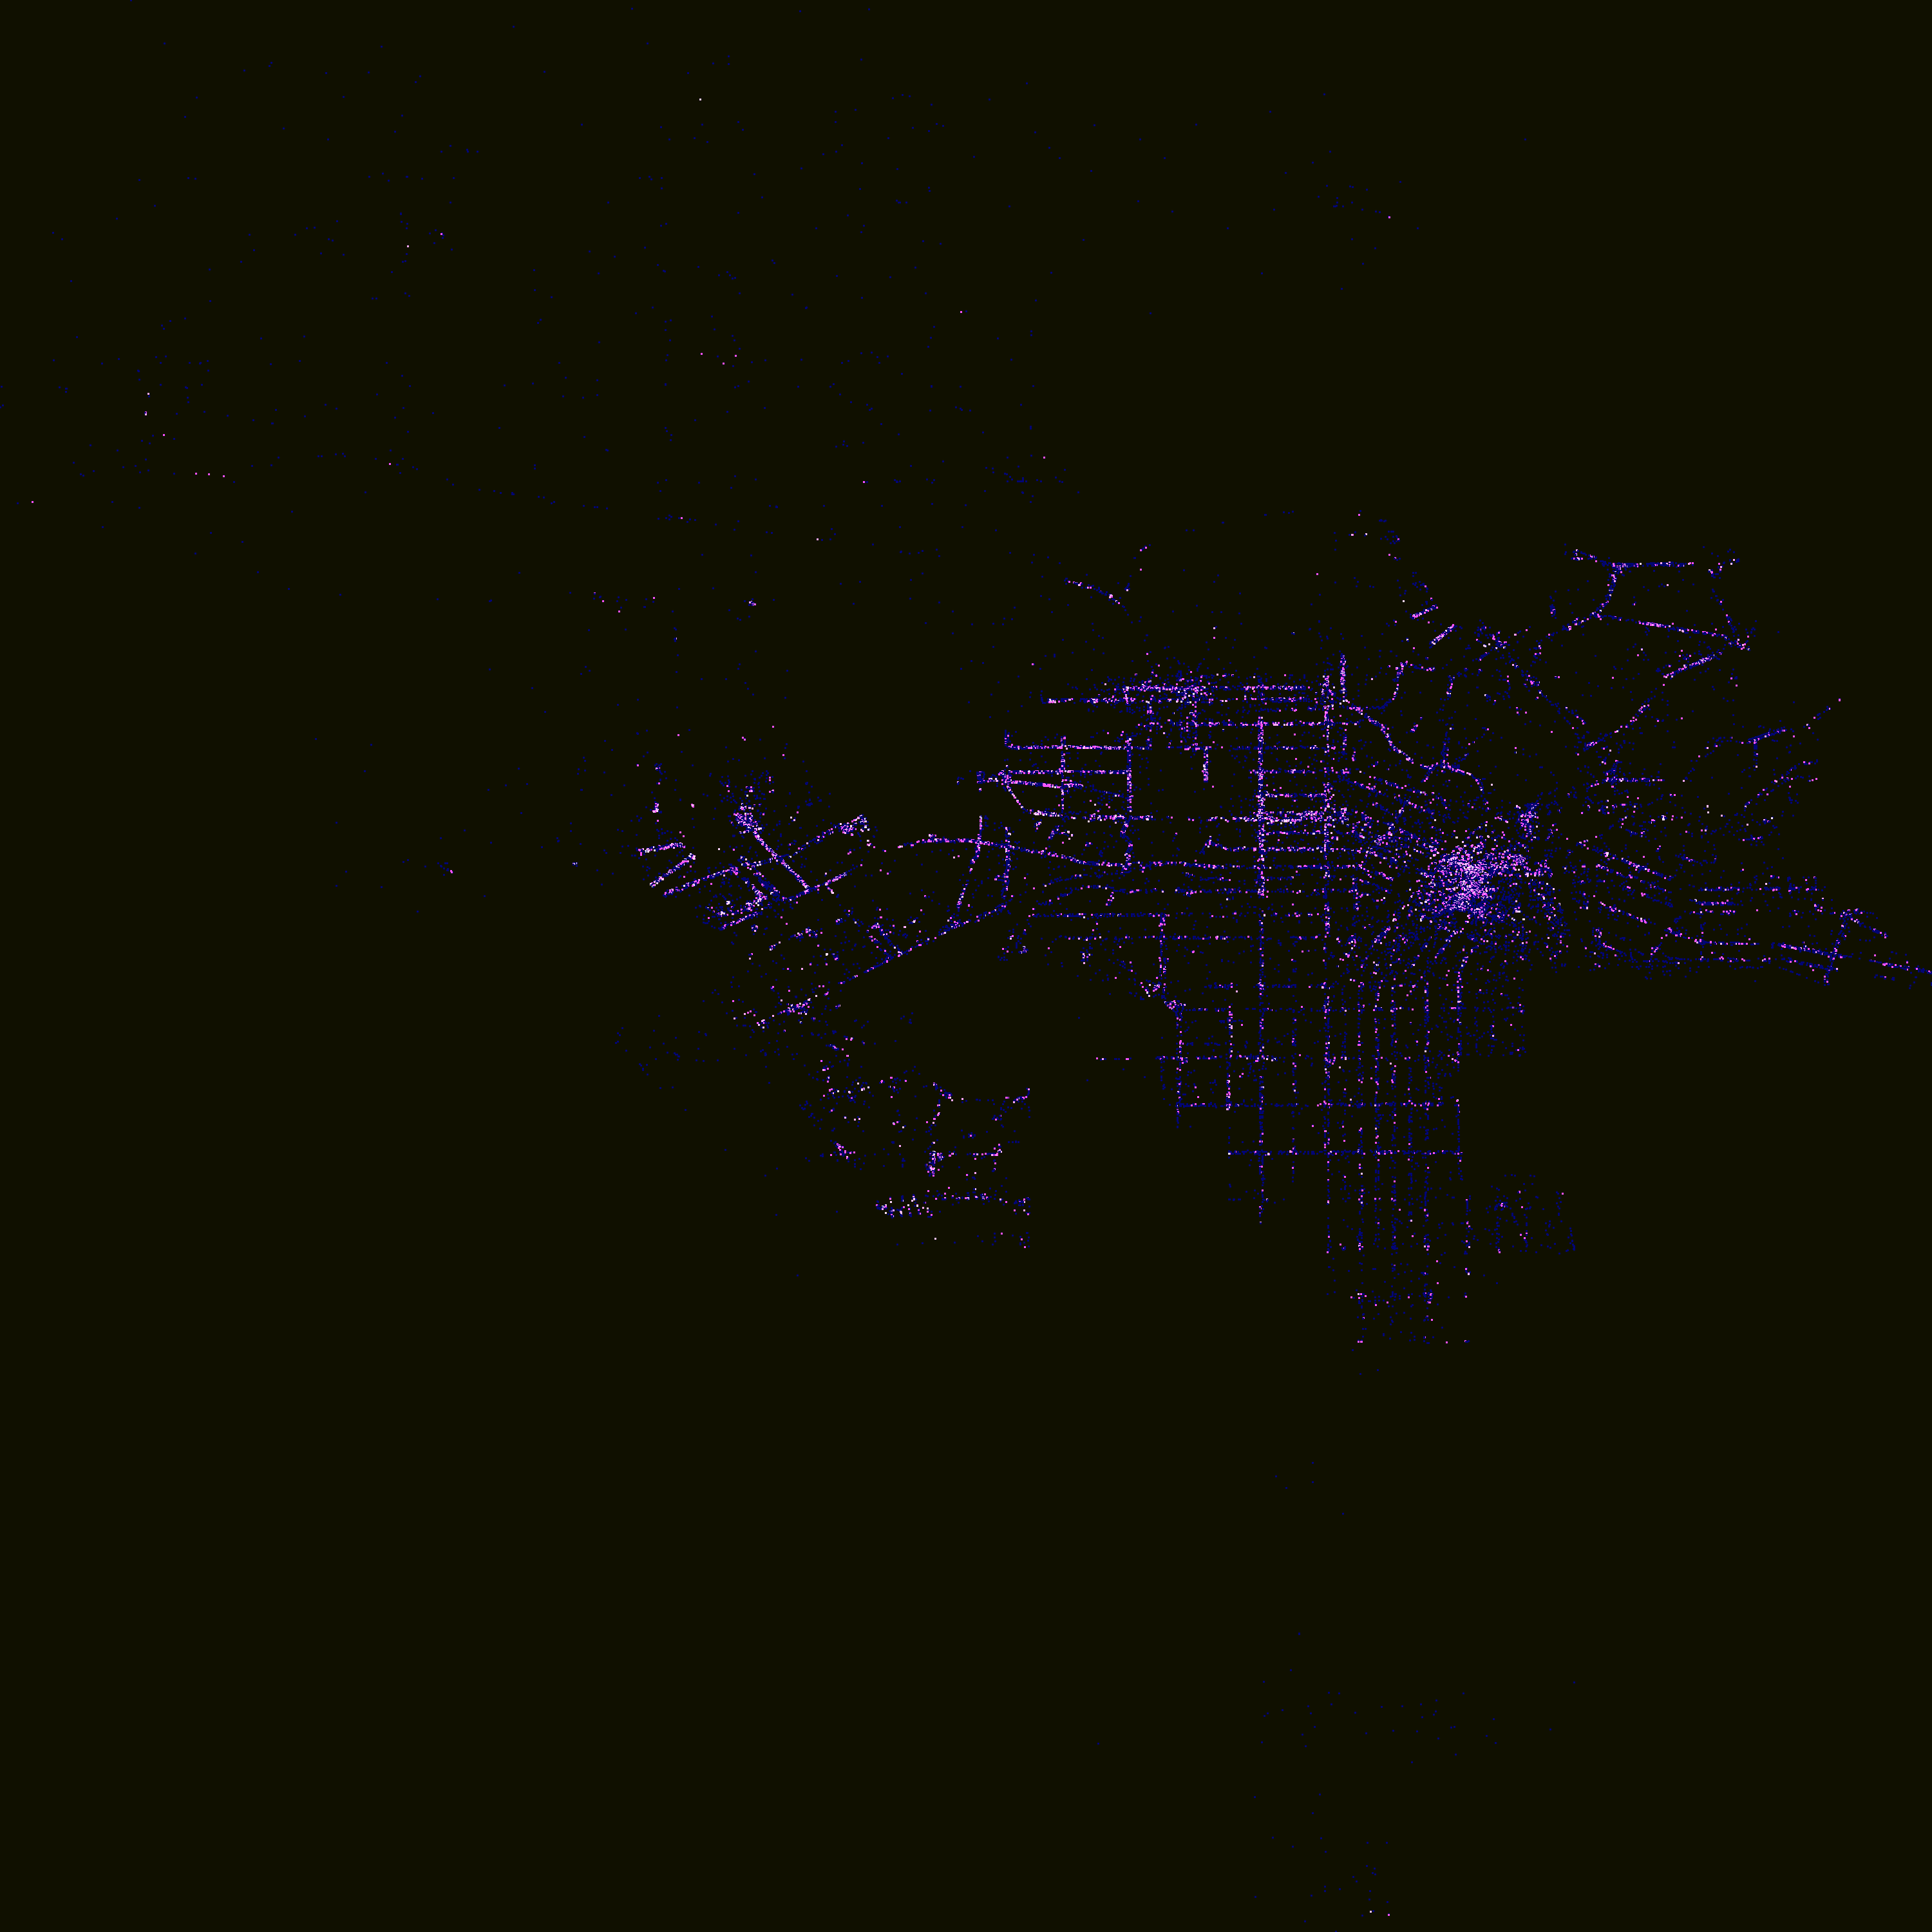

In [10]:
df['outlier_x'] = pd.qcut(df.X, 100, labels=False)
df['outlier_y'] = pd.qcut(df.Y, 100, labels=False)


for i in np.arange(1, 10):
    df = df[(df['X']!=df['X'].min()) & (df['Y']!=df['Y'].min())]
    df = df[(df['X']!=df['X'].max()) & (df['Y']!=df['Y'].max())]

range_x = (df['X'].min(), df['X'].max())
range_y = (df['Y'].min(), df['Y'].max())

wi = int(3000)
hi = int(3000)

cvs = ds.Canvas(plot_width=wi, plot_height=hi, x_range=range_x, y_range=range_y)
agg = cvs.points(df, "X", "Y", agg=ds.count())
img = tf.shade(agg, cmap=palette['CET_L7'][20:], how="eq_hist")
img = tf.spread(img, px=1, how='saturate')
img = tf.set_background(img, "#101000")

img

In [11]:
query = """
    SELECT longitude, latitude
    FROM `tidal-digit-291220.safegraph.places`
    WHERE city = 'Chicago' AND region = 'IL'
        """

In [12]:
df = bqclient.query(query).result().to_dataframe()

In [13]:
X, Y = lnglat_to_meters(df['longitude'], df['latitude'])

df['X'] = X
df['Y'] = Y

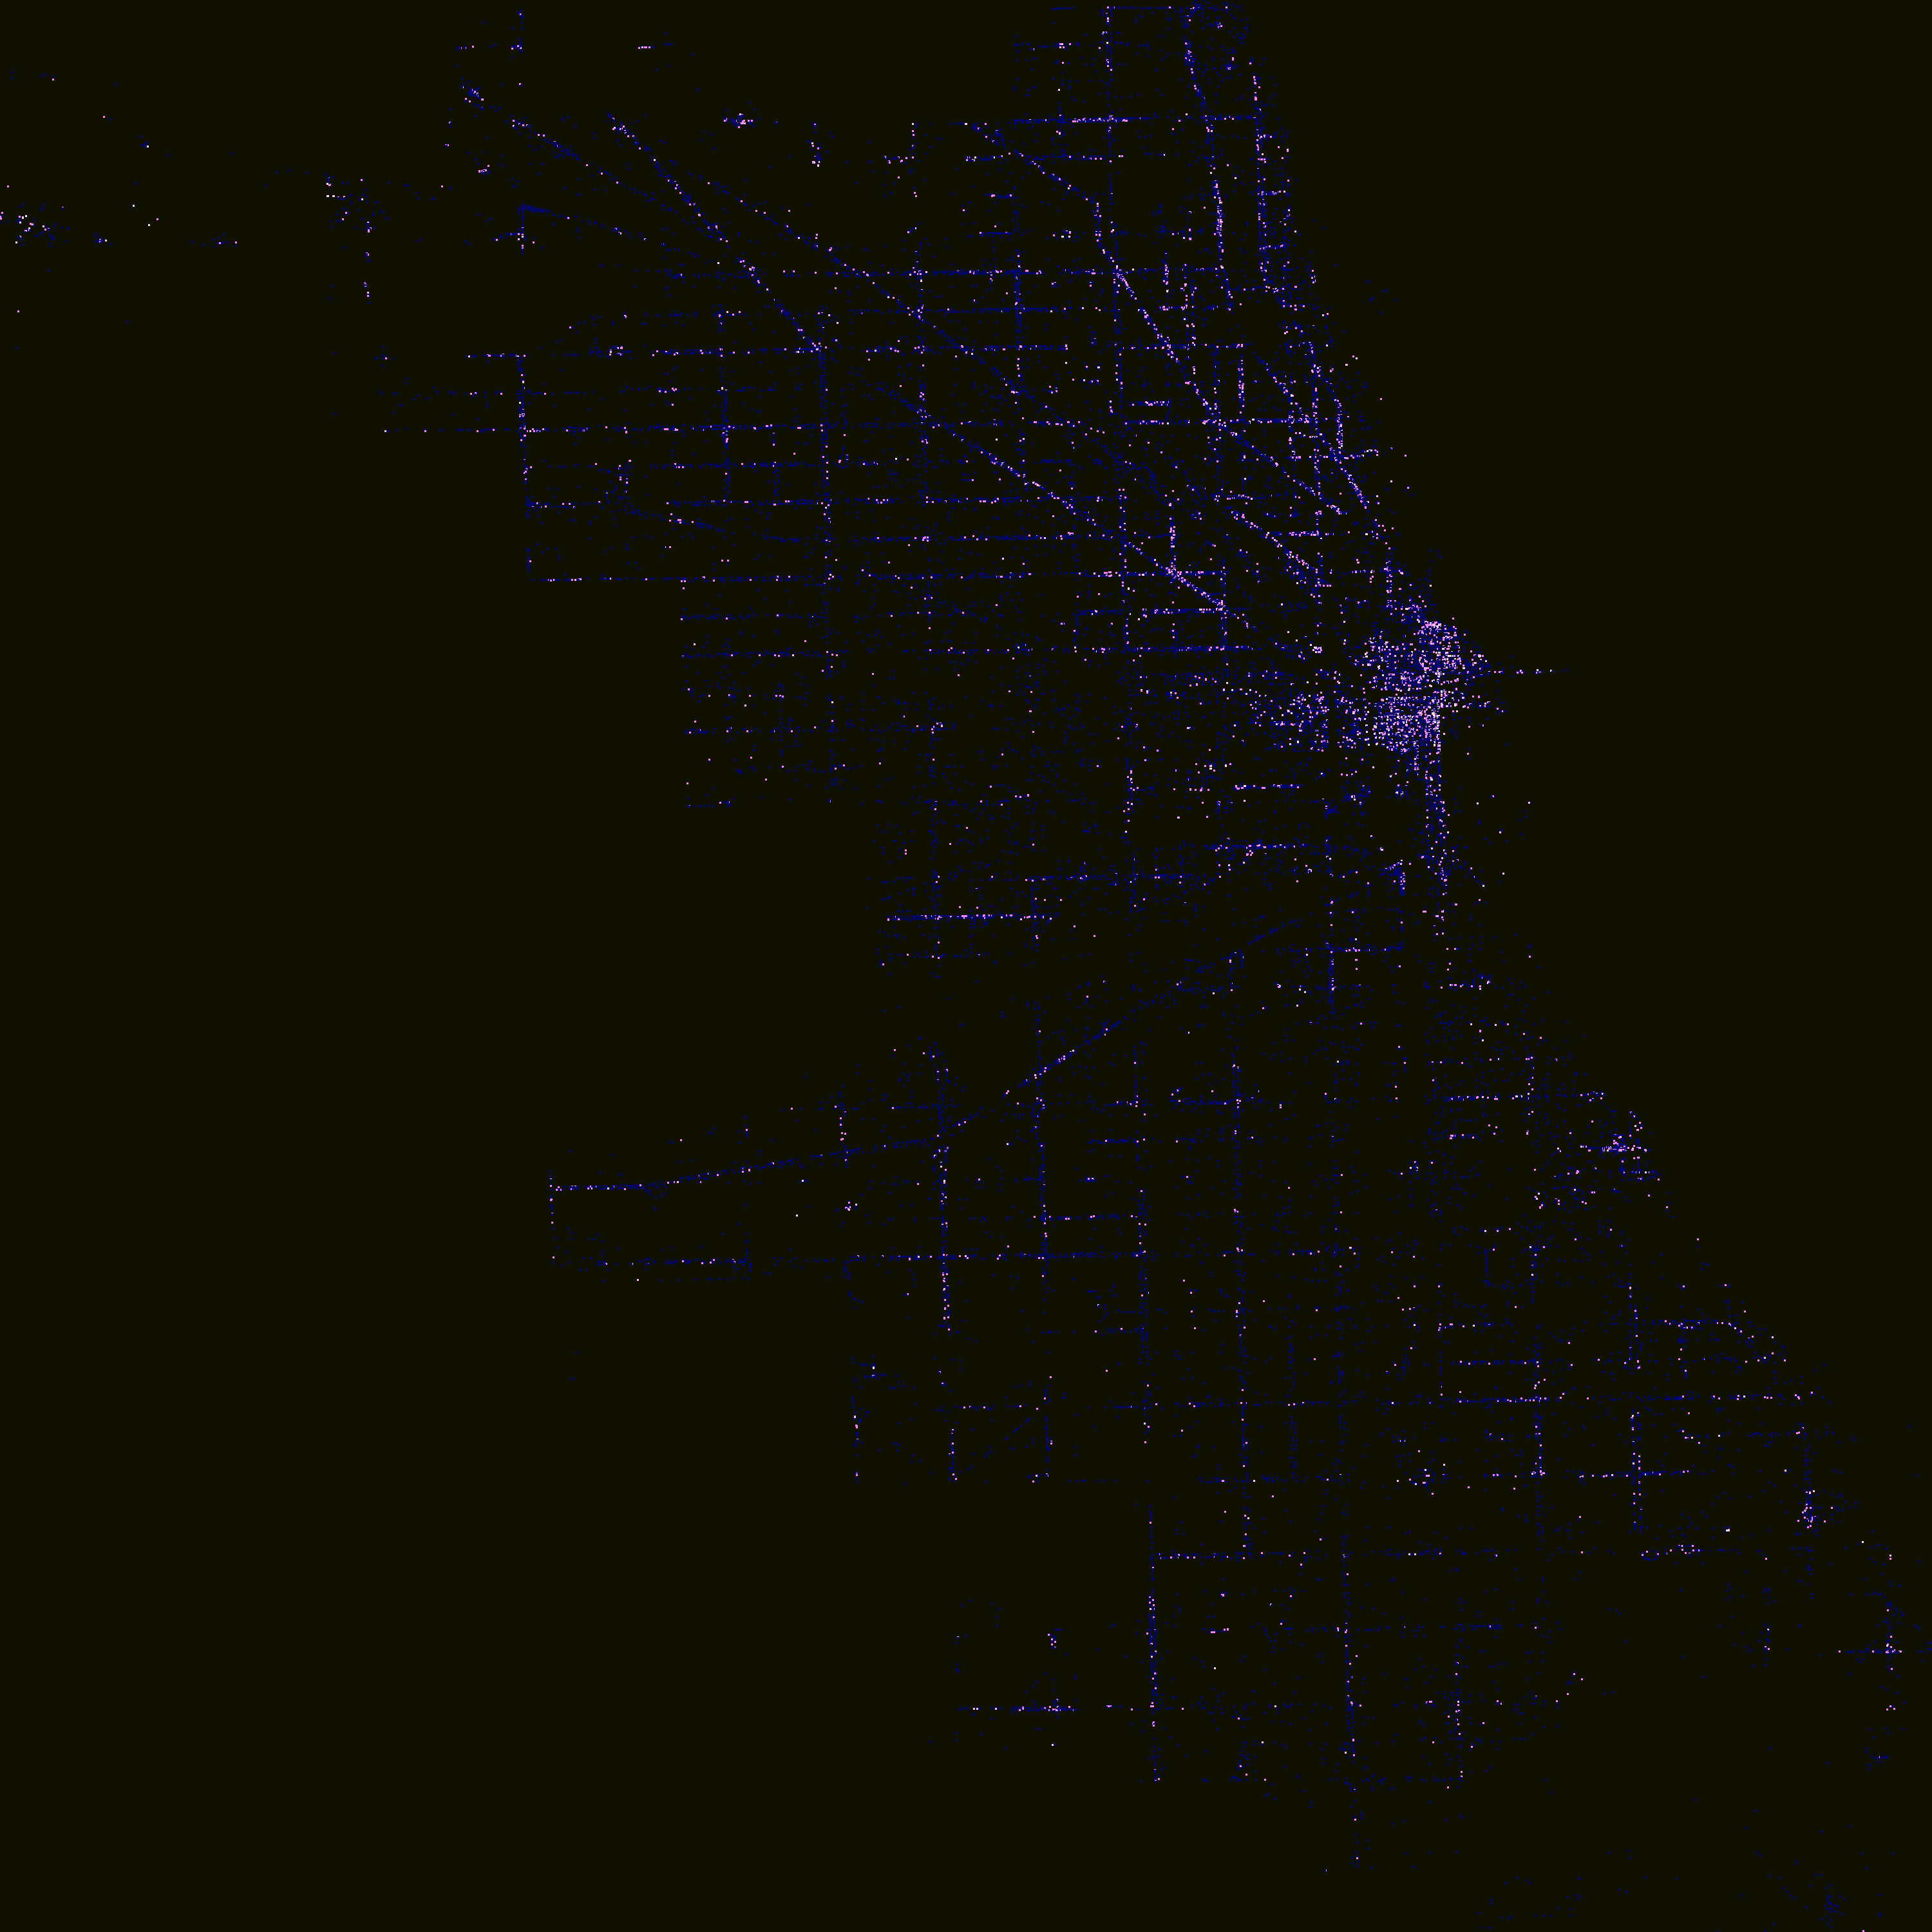

In [14]:
df['outlier_x'] = pd.qcut(df.X, 100, labels=False)
df['outlier_y'] = pd.qcut(df.Y, 100, labels=False)


for i in np.arange(1, 10):
    df = df[(df['X']!=df['X'].min()) & (df['Y']!=df['Y'].min())]
    df = df[(df['X']!=df['X'].max()) & (df['Y']!=df['Y'].max())]

range_x = (df['X'].min(), df['X'].max())
range_y = (df['Y'].min(), df['Y'].max())

wi = int(3000)
hi = int(3000)

cvs = ds.Canvas(plot_width=wi, plot_height=hi, x_range=range_x, y_range=range_y)
agg = cvs.points(df, "X", "Y", agg=ds.count())
img = tf.shade(agg, cmap=palette['CET_L7'][20:], how="eq_hist")
img = tf.spread(img, px=1, how='saturate')
img = tf.set_background(img, "#101000")

img

In [2]:
query = """
    SELECT poi_cbg, visitor_home_cbgs
    FROM `tidal-digit-291220.safegraph.2020_01`
    WHERE SUBSTR(CAST(poi_cbg AS STRING), 0, 5) = '36061' AND visitor_home_cbgs != '{}'
        """

In [3]:
raw = bqclient.query(query).result().to_dataframe()

In [7]:
import json

In [8]:
unnest = pd.json_normalize(raw.visitor_home_cbgs.apply(json.loads)).reset_index()
melted = unnest.melt(id_vars='index', var_name='visitor_home_cbgs', value_name='visits')

In [9]:
melted = melted.dropna()

In [10]:
joined = raw.reset_index().drop('visitor_home_cbgs', axis=1).merge(melted, 
                                                                   left_on='index', 
                                                                   right_on='index', 
                                                                   how='right').drop('index', axis=1)

In [11]:
joined = joined.dropna()

joined['poi_cbg'] = joined['poi_cbg'].astype('int64')
joined['visitor_home_cbgs'] = joined['visitor_home_cbgs'].astype('int64')

In [12]:
joined = joined.rename(columns={'poi_cbg': 'focal', 
                                'visitor_home_cbgs': 'target', 
                                'visits': 'weight'})

In [13]:
import cenpy

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [14]:
acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [15]:
state = "36"
boros = ["061", "085", "047", "005", "081"]

counties = list()

for boro in ["061", "085", "047", "005", "081"]:
    
    where_clause = f"STATE = {state} AND COUNTY = {boro}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    counties.append(block_groups)

blocks = gpd.GeoDataFrame(pd.concat(counties, ignore_index=True))

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
blocks = blocks.to_crs(3857)

In [18]:
nodes = pd.DataFrame({'X': blocks.centroid.x,
                      'Y': blocks.centroid.y,
                      'cbg': blocks.GEOID.astype('int64')}).set_index('cbg')

nodes.head()

X             Y
cbg                                     
360610138001 -8.232528e+06  4.979463e+06
360610255000 -8.232108e+06  4.989726e+06
360610261004 -8.230189e+06  4.989905e+06
360610261007 -8.230398e+06  4.989344e+06
360610273004 -8.230629e+06  4.990460e+06

In [19]:
edges = joined[joined['target'].isin(blocks['GEOID'])]
edges = edges.groupby(['focal', 'target']).weight.sum().reset_index()
edges = edges[edges['weight']>10]

edges.head()

focal        target  weight
19  360610001001  360610007001    13.0
32  360610001001  360610076001    12.0
36  360610001001  360610084002    13.0
39  360610001001  360610090001    12.0
41  360610001001  360610092001    19.0

In [20]:
%%time
g1 = connect_edges(nodes, edges,
                   source='focal', target='target',
                   x='X', y='Y')

CPU times: user 461 ms, sys: 20.9 ms, total: 482 ms
Wall time: 483 ms


In [21]:
%%time
g2 = hammer_bundle(nodes, edges,
                   source='focal', target='target',
                   decay=0.25,
                   x='X', y='Y')

CPU times: user 12.7 s, sys: 9.76 s, total: 22.4 s
Wall time: 14.7 s



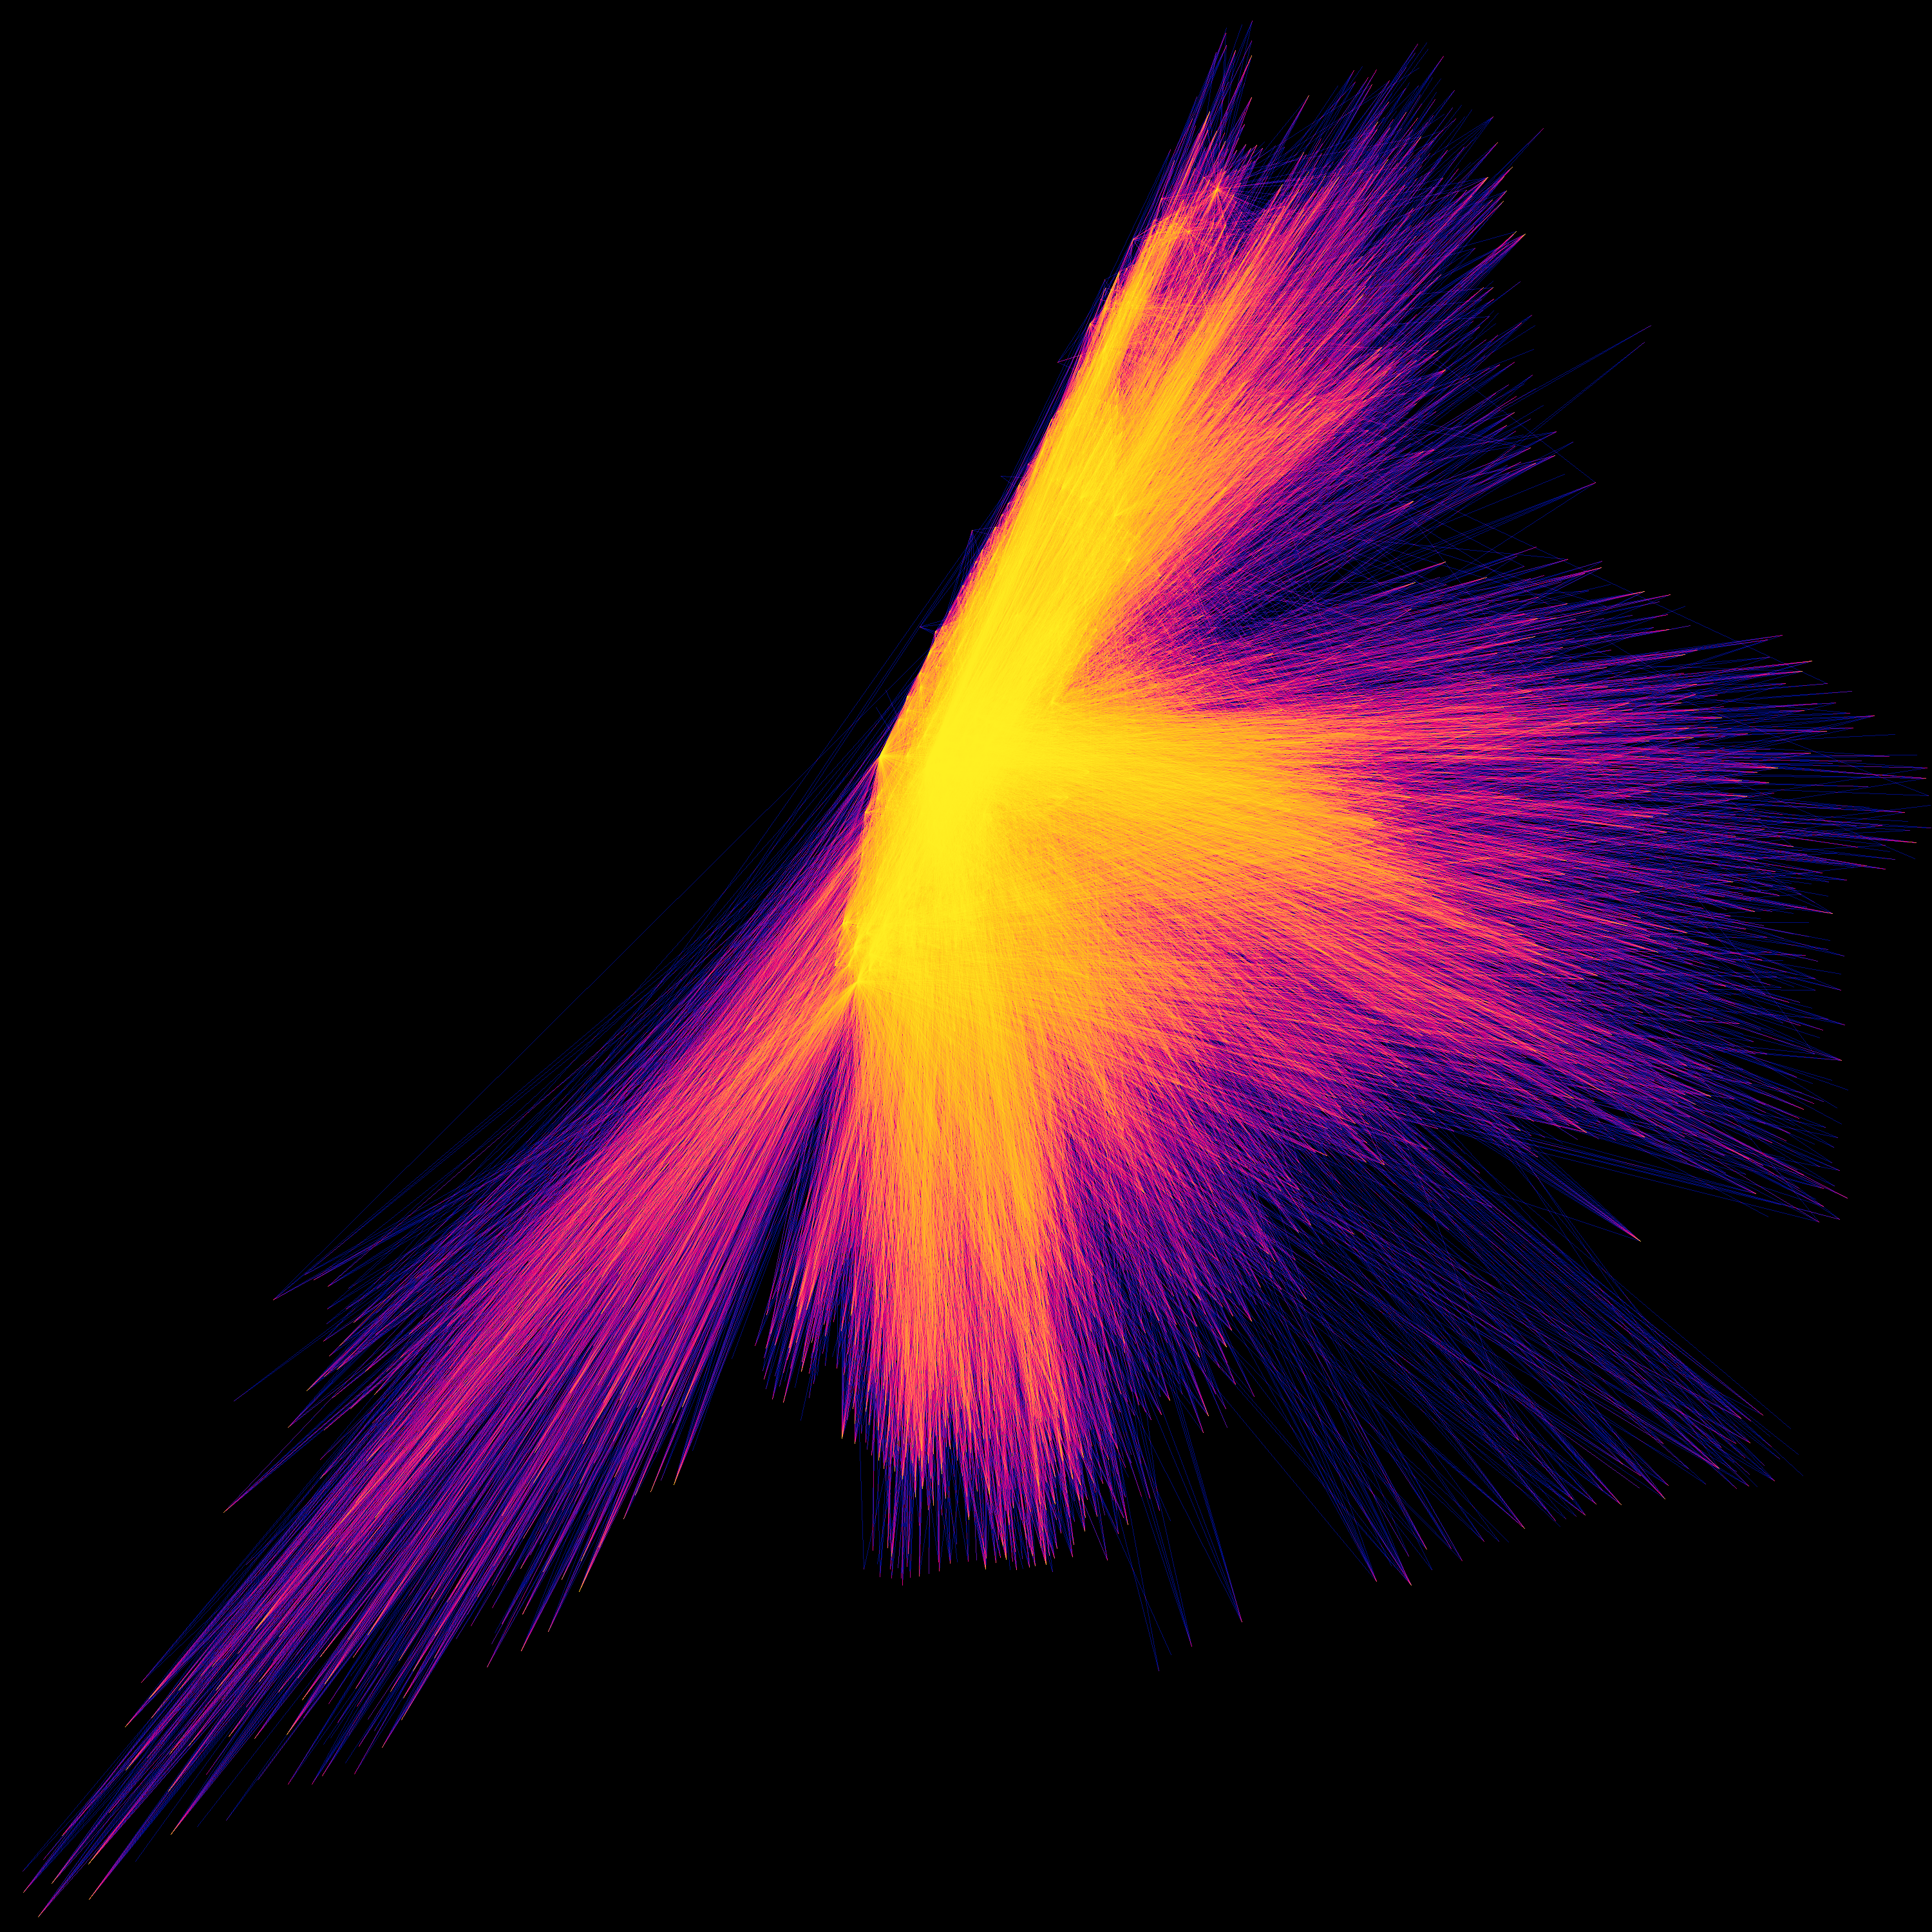
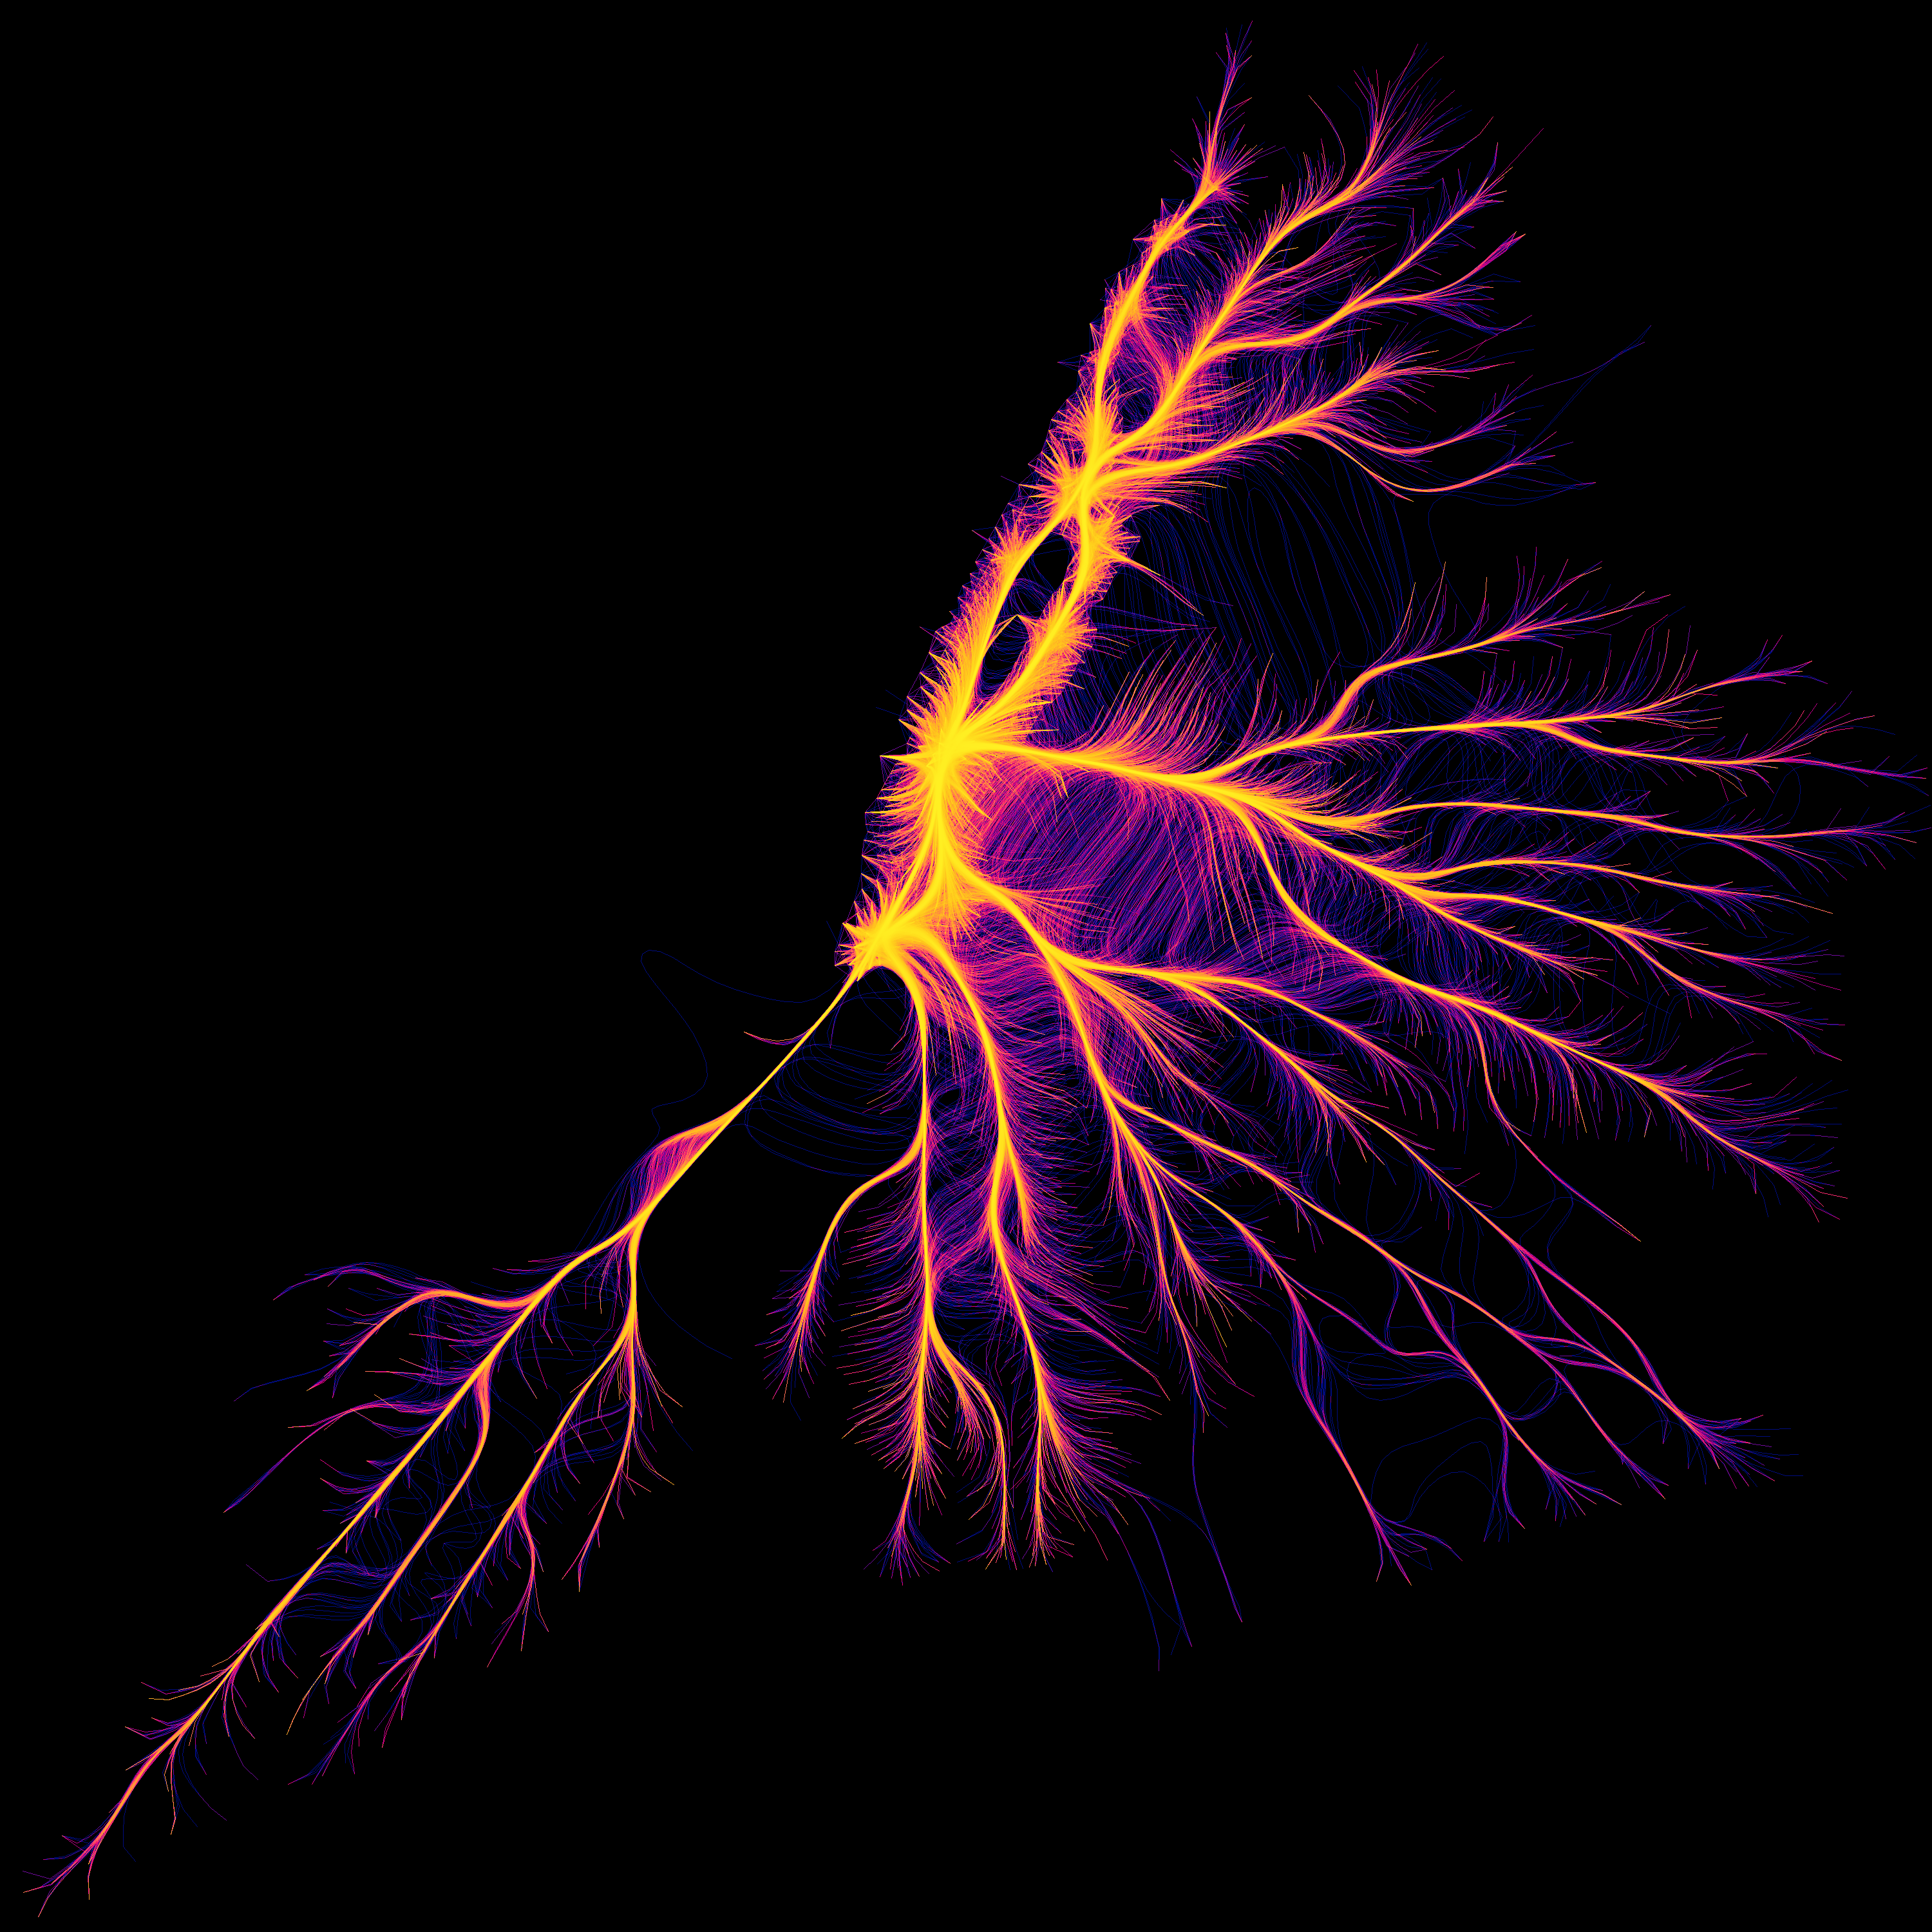

In [22]:
canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                   y_range=(nodes['Y'].min(), nodes['Y'].max()),
                   plot_height=3000, plot_width=3000)


p1 = tf.shade(canvas.line(g1, 'X', 'Y', agg=ds.count()),  cmap=palette['bmy'], how='eq_hist', name="Unbundled")

canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                   y_range=(nodes['Y'].min(), nodes['Y'].max()),
                   plot_height=3000, plot_width=3000)

p2 = tf.shade(canvas.line(g2, 'X','Y', agg=ds.count()), cmap=palette['bmy'], how='eq_hist', name="Bundled")

tf.Images(tf.set_background(p1, "#000000"), tf.set_background(p2, "#000000")).cols(2)